# 5.2 RNA速率

## 1. 背景

单细胞数据集允许以高分辨率研究如早期发育等生物过程。虽然对一个细胞进行测序后，它就被破坏了，因此其定义特性不能在以后的时间点再次测量，但是我们可以通过快照来研究不同状态的细胞。此外，值得注意的是，传统的实验技术不仅不能在不同的时间测量细胞的一般特性，而且也未能测量这些细胞变化发生的速度。但是我们却可以通过可*轨迹推断*（TI）领域的工具来恢复细胞的状态空间。但是传统的算法仅从细胞相似度以及表达矩阵两个维度去衡量，一定程度上缺失了相关内容。

## 2. RNA速率

细胞转录组谱的变化是由一系列事件触发的：广义上说，DNA被转录以产生所谓的未剪切前体信使RNA（pre-mRNA）。未剪切的pre-mRNA包含与翻译相关的区域（外显子）以及非编码区域（内含子）。这些非编码区域被剪切掉，即被移除，形成剪切、成熟的mRNA。尽管单细胞RNA测序（scRNA-seq）协议未能捕捉多个时间点的转录组，但它们确实包含了区分未剪切和剪切mRNA读取所需的信息。

识别未剪切和剪切读取允许构建描述剪切动力学的动态模型 ，并根据单细胞数据推断相应的模型权重。由模型描述的剪切RNA的变化被称为RNA速度。当前的RNA速度模型假设基因特定模型为

\[
    \begin{aligned}
        \frac{du}{dt} &= \alpha - \beta u\\
        \frac{ds}{dt} &= \beta u - \gamma s,
    \end{aligned}
\]

其中，$\alpha$是转录速率，$\beta$是剪切速率，$\gamma$是剪切RNA的降解速率。虽然每个基因的动力学是独立建模的，为了符号简洁，我们将去掉索引$g$。尽管动态系统中的参数估计领域已经被深入研究，但推断算法需要知道与每个观察值相关的时间。因此，这些传统方法不能应用于推断scRNA-seq数据背景下的RNA速度及其模型参数。

## 3. 模型假说

单细胞测序是快照数据，因此不能根据时间进行绘制。相反，传统的RNA速度方法依赖于研究每个基因的细胞特异性元组$(u, s)$，其中$u$和$s$分别代表未剪切和剪切的RNA。这些元组的集合形成所谓的相位图。假设转录、剪切和降解的速率是恒定的，相位图呈现出杏仁形状。上弧对应诱导阶段，下弧对应抑制阶段。然而，由于真实世界的数据是噪声的，绘制未剪切计数与剪切计数并不恢复预期的杏仁形状。相反，数据需要首先进行平滑处理。经典地，这个预处理步骤包括在细胞-细胞相似性图中对每个细胞的基因表达进行平均。

在本章教程中，我们将分别介绍**稳态模型**，**EM模型**和**深度学习模型**。


In [1]:
from tqdm import tqdm
from multiprocessing import Lock
tqdm.set_lock(Lock())  # manually set internal lock
tqdm.write("test")

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import omicverse as ov
ov.plot_set()

test

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


## 4. 加载数据

为了在本教程中演示方法，我们将在胚胎期(E)15.5使用小鼠胰腺发育的 scRNA-seq 数据集，这可以通过胰腺方便地访问[ Bastidas-Ponce 等，2019，Bergen 等，2020]。

我们观察剪接/未剪接读数的比例; 这些是估计 RNA 速度所必需的

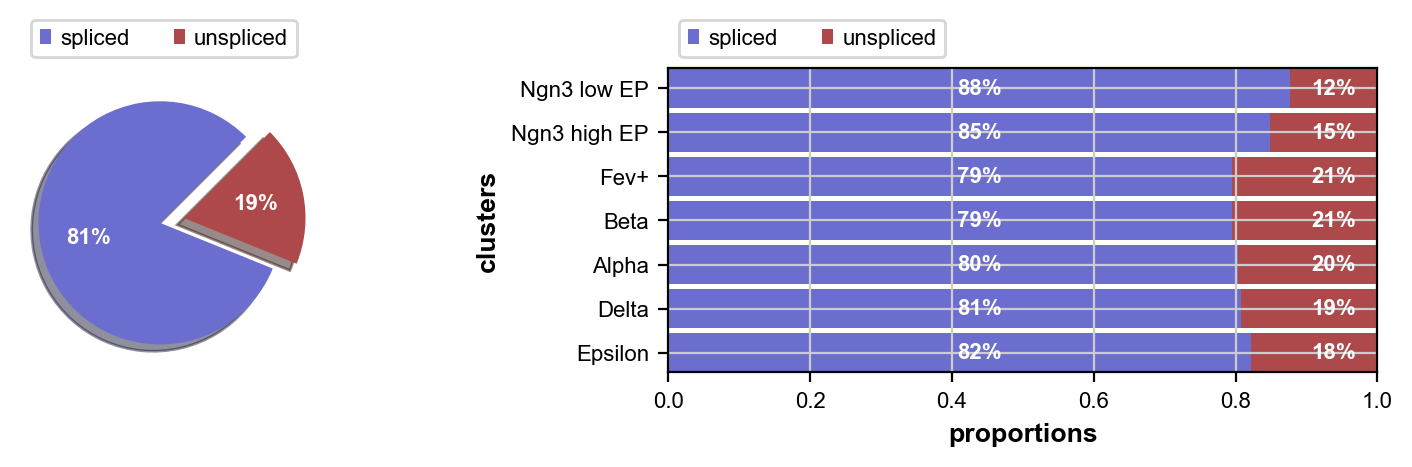

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [3]:
import cellrank as cr
import scvelo as scv
adata = cr.datasets.pancreas()
scv.pl.proportions(adata)
adata

## 5. 预处理数据

筛选出没有足够剪接/未剪接计数的基因，标准化并记录转换数据，限制在高度可变的顶部基因。进一步计算速度估计的主成分和矩。

In [4]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=50


/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 6. 稳态模型

我们估计RNA速度时假设基因是独立的，并且基础动力学由上述模型所规定。此外，我们还假设（1）动力学达到了平衡，（2）速率是恒定的，以及（3）所有基因都有一个单一的、共同的剪切速率。因此我们将这个模型称为*稳态模型*。稳态本身位于相位图的右上角（诱导阶段）和其原点（抑制阶段）。基于这些极端分位数，*稳态模型*使用线性回归拟合来估计稳态比率。然后，RNA速度被定义为与这个拟合的残差。

尽管*稳态模型*在某些系统中可以成功地恢复发展方向，但它由于其模型假设而固有地受到限制。容易违反的两个假设是所有基因具有相同的剪切速率，以及在实验过程中观察到的平衡状态。因此，在这些情况下的推断将产生错误的结果。此外，*稳态模型*只考虑数据的一个子集，并且只推断稳态比率，而不是每个模型参数。


我们在稳态模型下计算RNA速度。在这种情况下，我们使用*scVelo*的`velocity`函数，并设置`mode="deterministic"`。

In [5]:
scv.tl.velocity(adata, mode="deterministic")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


虽然我们不鼓励过度解释将高维速度向量投影到数据的低维表示，但*scVelo*提供了一个简单的方法来实现这一点。

computing velocity graph (using 8/12 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


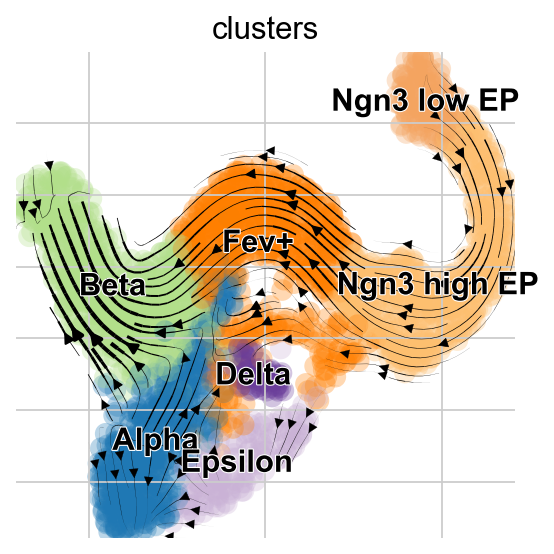

In [7]:
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(adata, basis="umap", color="clusters")

## 7. EM模型

为了克服*稳态模型*的局限性，已经提出了几种扩展方法。迄今为止最受欢迎的是在scVelo中实施的*EM模型*。*EM模型*不再假设已达到稳态，也不假设基因具有共同的剪切速率。此外，所有数据点都用于推断完整的参数集，以及剪切模型的基因和细胞特定的潜在时间。该算法使用期望最大化（EM）框架来估计参数。在E步中找到的未观察到的变量包括每个细胞的时间和状态（诱导、抑制或稳态）。所有其他的模型参数在M步中被推断。

虽然*EM模型*不再依赖于*稳态模型*的关键假设，因此更具广泛的适用性，但推断出的RNA速度仍可能违反先前的生物学知识。这种失败的原因主要有两个方面：一方面，*EM模型*仍然假设速率是恒定的。因此，每当这些假设不成立时，例如在红细胞成熟过程中，推断就是不正确的。另一方面，所提议的模型依赖于相位图作为其前身。因此，当基因相位图不遵循预期的形状时，该算法固有地不适用并失败。


为了使用*EM模型*计算RNA速度，首先需要推断剪切动力学的参数。推断由*scVelo*的`recover_dynamics`函数处理。

In [8]:
scv.tl.recover_dynamics(adata, n_jobs=8)

recovering dynamics (using 8/12 cores)


  0%|          | 0/783 [00:00<?, ?gene/s]

    finished (0:00:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


剪切模型的参数是通过最大化给定的似然函数来推断的。为了研究哪些基因被*scVelo*最自信地拟合，我们可以研究相应的相位图以及推断出的轨迹（紫色绘制）和稳态比率（虚线紫色线）。在这里，五个显示的基因中有两个呈现出（*Pcsk2*,*Gcg*、*Ank*）杏仁形状的相位图。我们观察到明确的转变.

在单个细胞类型内部（*Gcg*、*Ghr1*）还是跨越几个细胞类型（*Pcsk2*，从Ngn3 low EP到Alpha和Beta）。而在*Gng12*的情况下，我们观察到一个细胞群处于稳态。这很可能是由于在Ngn3低/高EP细胞周围的表型流形下采样不足而产生的伪迹。尽管由于小的聚类大小只有少数细胞。虽然目前的最佳实践仅限于手动分析模型的拟合度和其中的置信度，但最近提出的方法可以帮助自动化这个过程（新方向）。在这里，*Gcg*和*Ghrl*将被分配一个较低的置信度分数。

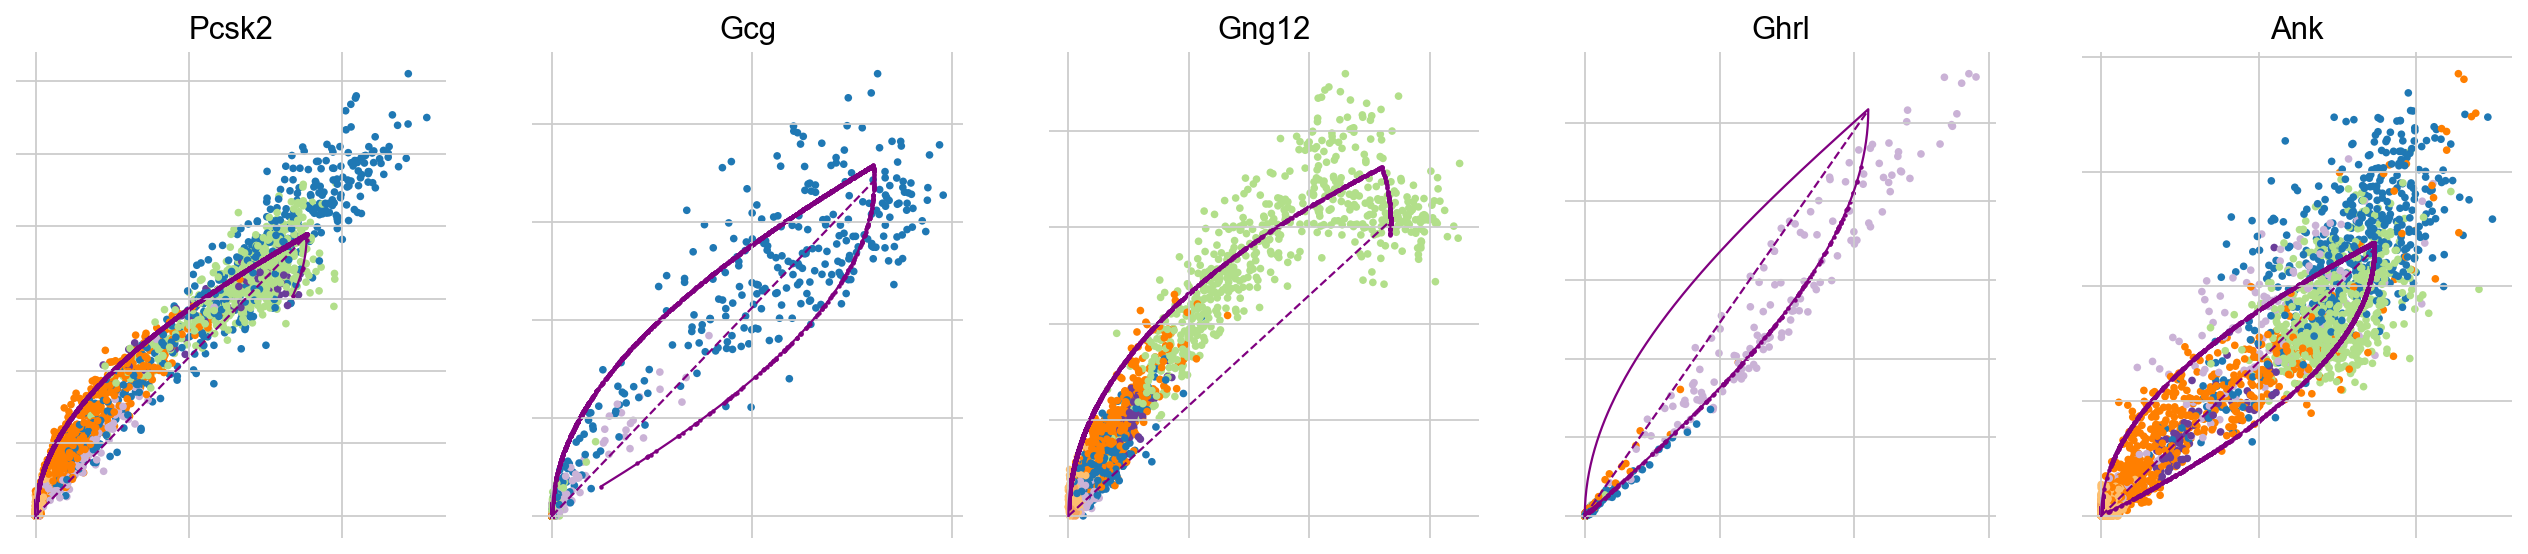

In [11]:
top_genes = adata.var["fit_likelihood"].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:5], color="clusters", frameon=False)

在估计了动力学速率（存储为`adata.obs`的`fit_alpha`、`fit_beta`、`fit_gamma`列）之后，我们可以计算速度，并将其投影到我们的二维UMAP嵌入中。

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 8/12 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


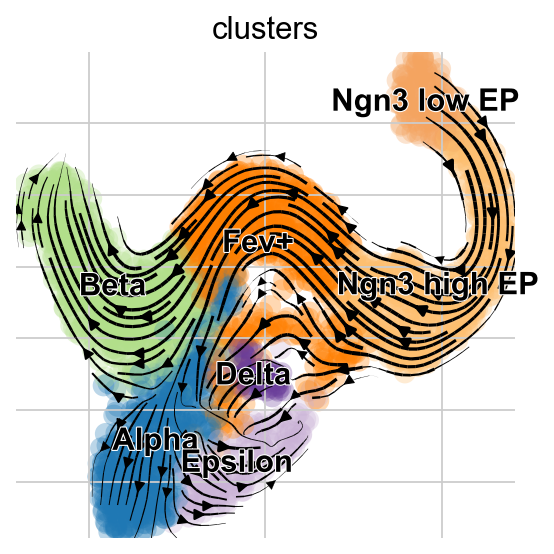

In [12]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(adata, basis="umap")

稳态模型的投影展示了从Alpha细胞到Pre-endocrine细胞的“回流”，但是EM模型没有这一现象的出现。

动力学模型恢复了潜在的细胞过程的时间。这个潜在的时间代表了细胞的内部时钟，并且仅基于其转录动力学来近似细胞在分化过程中所经历的实际时间。

In [13]:
scv.tl.latent_time(adata)
adata.obs['latent_time_EMmodel']=adata.obs['latent_time'].copy()

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [16]:
adata.obs['velocity_pseudotime_EMmodel']=adata.obs['velocity_pseudotime'].copy()

## 8. 深度学习模型

尽管这些用于估计RNA速度的方法已成功用于解释单细胞动力学，但它们也受到由于建模假设和下游使用所导致的限制。例如，这两种方法都缺乏全局的不确定性概念。因此，评估RNA速度估计的稳健性，或者决定速度分析在给定数据集中适用的程度可能会很困难。

veloVI（速度变分推断）是一个用于估计RNA速度的深度生成模型。VeloVI通过一个模型重新表述了RNA速度的推断，该模型在所有细胞和基因之间共享信息，同时学习与EM模型中相同的数量，即动力学参数和潜在时间。这种重新表述利用了深度生成建模的进展20，这些进展已经成为许多单细胞组学分析任务的核心，如多模态数据集成、扰动建模和数据校正。作为其输出，veloVI返回了RNA速度的经验后验分布（细胞-基因-后验样本的矩阵），这可以纳入到结果的下游分析中。此外，它提供了一个解释层和模型批评，这是以前方法所缺乏的，同时也极大地提高了模型扩展的灵活性。

我们可以导入VeloVI，进而研究深度学习模型下的拟时序值

In [17]:
#adata = preprocess_data(adata)
from velovi import VELOVI
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 500/500: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s, loss=-9.3e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s, loss=-9.3e+03, v_num=1]


In [18]:
import torch
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

computing velocity graph (using 8/12 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


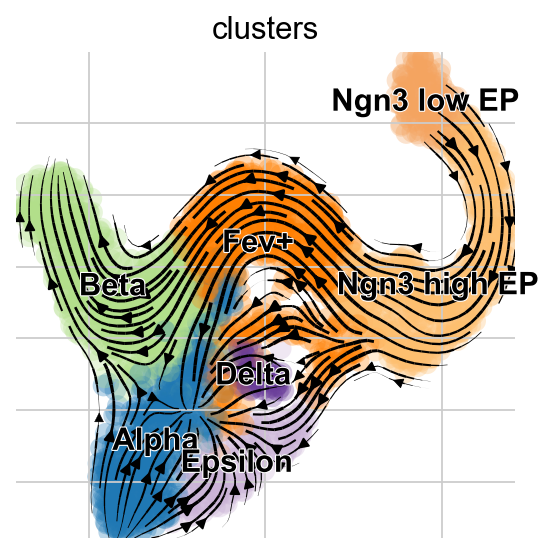

In [19]:
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(adata, basis="umap")

有趣的是，深度学习模型捕获了Alpha和Epsilon细胞的回流

In [20]:
scv.tl.latent_time(adata)
adata.obs['latent_time_velovi']=adata.obs['latent_time'].copy()

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [21]:
adata.obs['velocity_pseudotime_velovi']=adata.obs['velocity_pseudotime'].copy()

对比不同的模型拟时序值，我们可以使用embedding可视化潜伏时间

/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/omicverse/utils/_scatterplot.py:483: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(cax, orientation="vertical", cax=cax1)


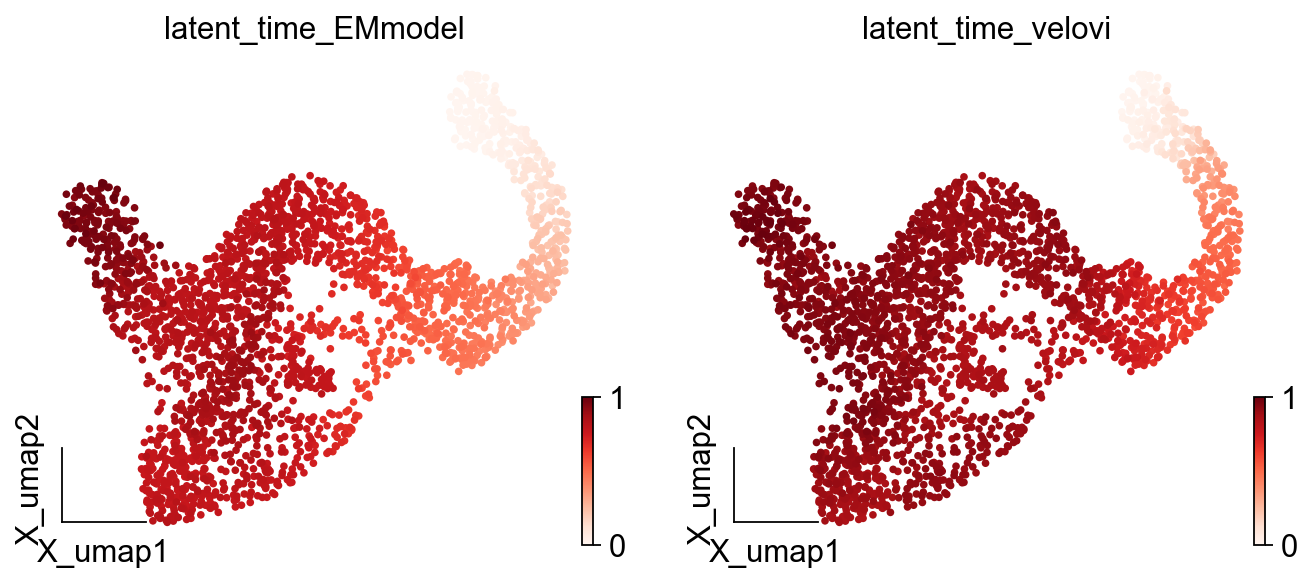

In [22]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['latent_time_EMmodel','latent_time_velovi'],
                   frameon='small',cmap='Reds')

## 9. 注意事项

为了理解RNA速度分析是否适用于给定的数据集，我们指出以下几点：

1. 为了推断RNA速度，所研究的发育过程的时间尺度必须与RNA分子的半衰期相当。例如，在胰腺内分泌发育中，这个要求得到了满足，但在像阿尔茨海默病或帕金森病这样的长期疾病中则不然。同样，对于缺乏任何转换的稳态系统（如外周血单个核细胞），RNA速度分析也不适用。
2. 只有当底层模型的假设（大约）成立时，才可以稳健且可靠地推断RNA速度。为了检查这些假设，可以研究相位图以验证它们是否呈现预期的杏仁形状。如果一个基因包含多个明显的动力学，应谨慎应用RNA速度分析，并可能将数据子集化到单个谱系。
3. 传统上，高维RNA速度向量通过将它们投影到数据的低维表示来可视化。这种验证假设的方法可能是错误和误导的，因为投影的速度流高度依赖于（1）包括的基因数量和（2）选择的绘图参数。此外，低维嵌入的边界处的投影质量会下降。